In [41]:
#Load and clean : step 0
import pandas as pd

df = pd.read_csv("../data/processed_churn_data.csv")
df.head()


state  account length  area code  phone number  international plan  \
0     16             128        415          1926                   0   
1     35             107        415          1575                   0   
2     31             137        415          1117                   0   
3     35              84        408          1707                   1   
4     36              75        415           110                   1   

   voice mail plan  number vmail messages  total day minutes  total day calls  \
0                1                     25              265.1              110   
1                1                     26              161.6              123   
2                0                      0              243.4              114   
3                0                      0              299.4               71   
4                0                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...               99             16.78   
1             27.47  ...              103             16.62   
2             41.38  ...              110             10.30   
3             50.90  ...               88              5.26   
4             28.34  ...              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False  

[5 rows x 21 columns]

In [42]:
#Train Test split karyu model ne 

from sklearn.model_selection import train_test_split

X = df.drop("churn", axis=1)
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

len(X_train), len(X_test)


(2666, 667)

In [43]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After SMOTE:", y_train_bal.value_counts(normalize=True))


Before SMOTE: churn
False    0.855214
True     0.144786
Name: proportion, dtype: float64
After SMOTE: churn
False    0.5
True     0.5
Name: proportion, dtype: float64


In [44]:
from xgboost import XGBClassifier

model = XGBClassifier(
    learning_rate=0.05,
    n_estimators=300,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss"
)

model.fit(X_train_bal, y_train_bal)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)


Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.95      0.95       570
        True       0.70      0.70      0.70        97

    accuracy                           0.91       667
   macro avg       0.83      0.83      0.83       667
weighted avg       0.91      0.91      0.91       667


ROC-AUC Score: 0.8831072526677518


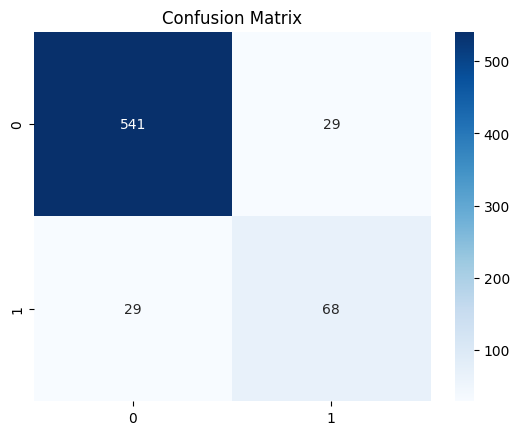

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

print("\nClassification Report:")
print(classification_report(y_test, preds))

print("\nROC-AUC Score:", roc_auc_score(y_test, probs))

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix")
plt.show()


PermutationExplainer explainer: 668it [01:11,  8.03it/s]                         
C:\Users\Om Panchal\AppData\Local\Temp\ipykernel_22360\1339314529.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)


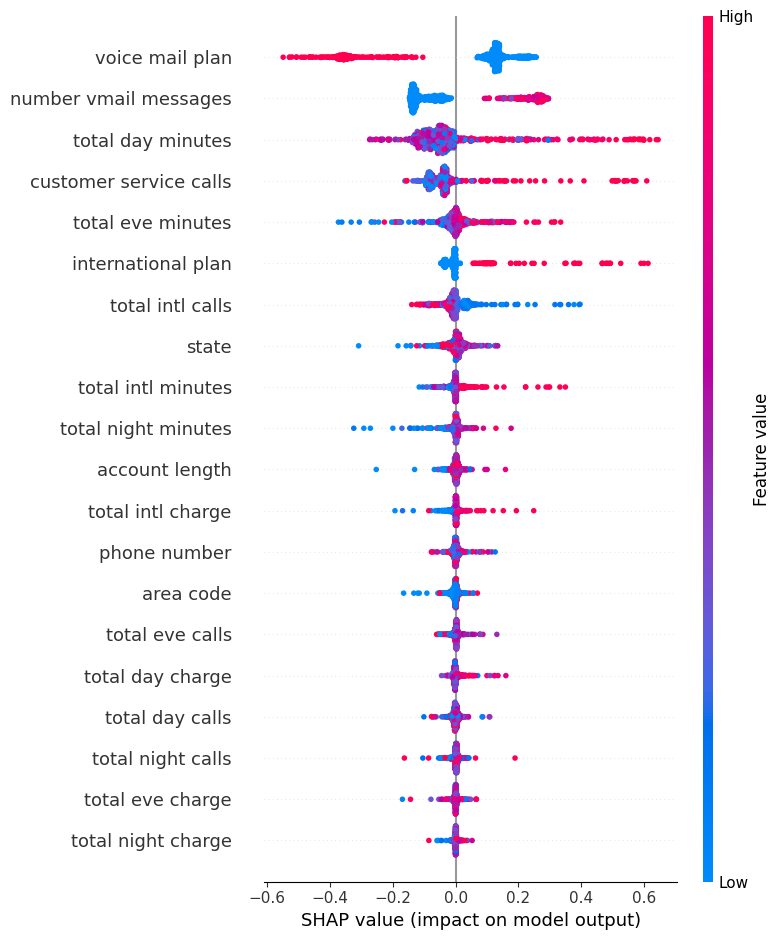

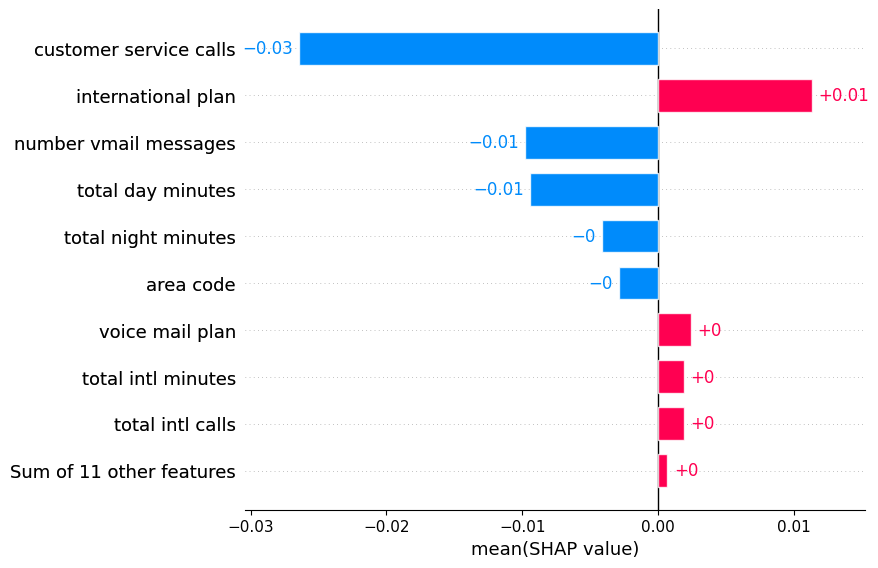

In [46]:
import shap

# Create explainer using model prediction function
explainer = shap.Explainer(model.predict, X_train)

# Compute shap values
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)
shap.plots.bar(shap_values.mean(0), max_display=10)



In [47]:
import pickle

pickle.dump(model, open("../saved_models/retention_model.pkl", "wb"))

print(" Model saved as retention_model.pkl")


 Model saved as retention_model.pkl
